<a href="https://colab.research.google.com/github/tanyarw/virtual-makeup/blob/main/virtual_makeup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#mount in drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#change file directory
import os
os.chdir("drive/My Drive/ML Lab/virtual makeup")

In [3]:
import cv2
import sys
import numpy as np
import dlib
from google.colab.patches import cv2_imshow

# Find facial features

Input Image

In [4]:
imgPath = "face1.jpg"
img = cv2.imread(imgPath)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

Detect face using Haar Cascade

In [5]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.3,
        minNeighbors=3,
        minSize=(30, 30)
)

print("Found",len(faces),"Faces!".format())

Found 1 Faces!


Plot face detected

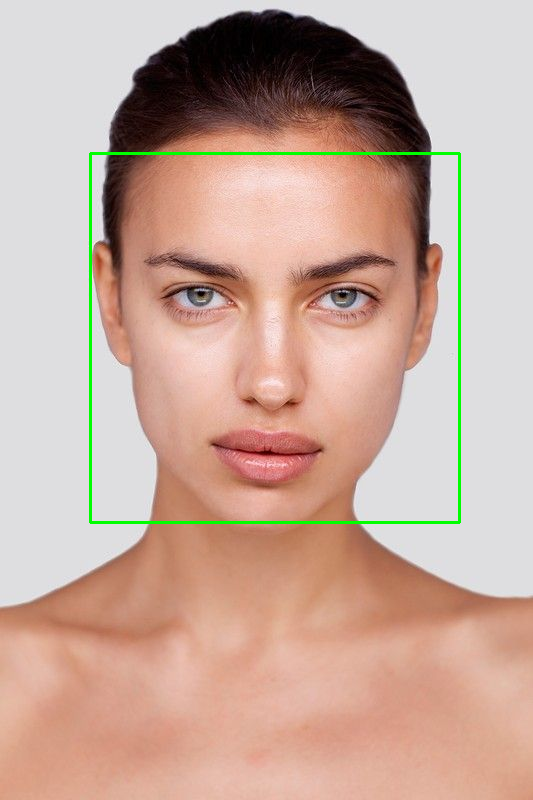

In [6]:
imgcpy1 = img.copy() # copy of image
for (x, y, w, h) in faces:
    cv2.rectangle(imgcpy1, (x, y), (x+w, y+h), (0, 255, 0), 2)
cv2_imshow(imgcpy1)

Detect landmark features using dlip plots

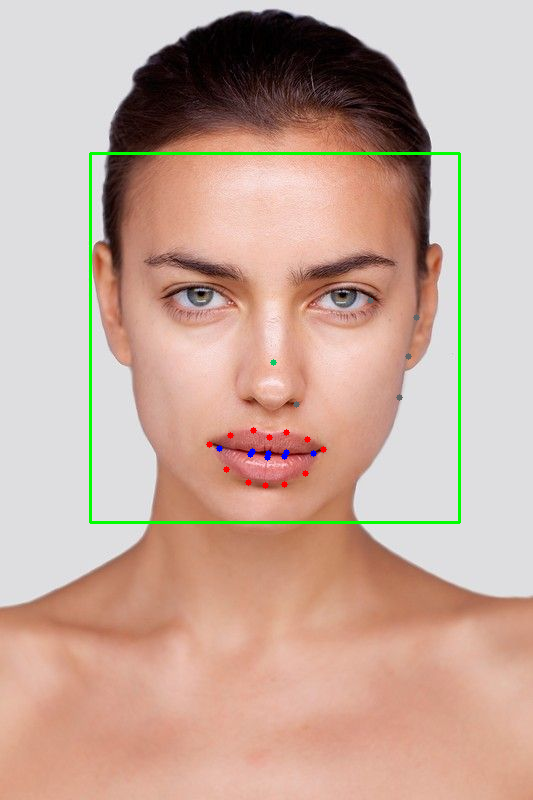

In [7]:
# outer lip coordinates
outer_lip_x = []
outer_lip_y = []
# inner lip coordinates
inner_lip_x = []
inner_lip_y = []
# mid of face
mid_x = []
mid_y = []
# left cheek boundary
cheek_left_x = []
cheek_left_y = []
# right cheek boundary
cheek_right_x = []
cheek_right_y = []


# Load the detector
detector = dlib.get_frontal_face_detector()
# Load the predictor
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# Use detector to find landmarks
faces = detector(gray)
for face in faces:
    x1 = face.left() # left point
    y1 = face.top() # top point
    x2 = face.right() # right point
    y2 = face.bottom() # bottom point
    # Create landmark object
    landmarks = predictor(image=gray, box=face)
    # Loop through all the points
    with open('points.txt', 'w') as writefile:
      for n in range(0, 68):
          x = landmarks.part(n).x
          y = landmarks.part(n).y
          writefile.write(str(x)+" "+str(y)+"\n")

          if n==29:
            mid_x.append(x)
            mid_y.append(y)
            cv2.circle(img=imgcpy1, center=(x, y), radius=3, color=(100, 200, 10), thickness=-1) # plot mid

          if n in range(13,16) or n in (35,45):
            cheek_right_x.append(x)
            cheek_right_y.append(y)
            cv2.circle(img=imgcpy1, center=(x, y), radius=3, color=(100, 100, 100), thickness=-1) # plot right cheek

          if n in range(48,60):
            outer_lip_x.append(x)
            outer_lip_y.append(y)
            cv2.circle(img=imgcpy1, center=(x, y), radius=3, color=(0, 0, 255), thickness=-1) # plot outerlips
          if n in range(60,68):
            inner_lip_x.append(x)
            inner_lip_y.append(y)
            cv2.circle(img=imgcpy1, center=(x, y), radius=3, color=(255, 0, 0), thickness=-1) # plot innerlips
          

# show the image
cv2_imshow(imgcpy1)

outer_lip_x = np.array(outer_lip_x)
outer_lip_y = np.array(outer_lip_y)
inner_lip_x = np.array(inner_lip_x)
inner_lip_y = np.array(inner_lip_y)
cheek_left_x = np.array(cheek_left_x)
cheek_left_y = np.array(cheek_left_y)
cheek_right_x = np.array(cheek_right_x)
cheek_right_y = np.array(cheek_right_y)

# Add layers of "lipstick"



In [8]:
from pylab import *
from scipy import interpolate
from scipy.interpolate import interp1d
from skimage import color
import matplotlib.pyplot as plt

In [9]:
b1, g1, r1 = (5., 20., 250.)  # lipstick color
outer_left_end = 4
outer_right_end = 7
inner_left_end = 3
inner_right_end = 5

In [10]:
def inter(lx, ly, k1='quadratic'):
    unew = np.arange(lx[0], lx[-1] + 1, 1) # evenly spaced values within given interval
    f2 = interp1d(lx, ly, kind=k1, fill_value="extrapolate")
    return f2, unew

Code for the curves bounding the lips

In [11]:
outer_upper_left = inter(outer_lip_x[:outer_left_end],
                    outer_lip_y[:outer_left_end])
outer_upper_right = inter(outer_lip_x[outer_left_end - 1:outer_right_end],
                    outer_lip_y[outer_left_end - 1:outer_right_end])

x1 = [outer_lip_x[0]] + outer_lip_x[outer_right_end - 1:][::-1].tolist()
y1 = [outer_lip_y[0]] + outer_lip_y[outer_right_end - 1:][::-1].tolist()
outer_lip = inter(x1, y1, 'cubic')

inner_upper_left = inter(inner_lip_x[:inner_left_end], inner_lip_y[:inner_left_end])
inner_upper_right = inter(inner_lip_x[inner_left_end - 1:inner_right_end], inner_lip_y[inner_left_end - 1:inner_right_end])

x2 = [inner_lip_x[0]] + inner_lip_x[inner_right_end - 1:][::-1].tolist()
y2 = [inner_lip_y[0]] + inner_lip_y[inner_right_end - 1:][::-1].tolist()
inner_lip = inter(x2, y2, 'cubic')



In [12]:
x = []  # will contain the x coordinates of points on lips
y = []  # will contain the y coordinates of points on lips

def extension(a, b, i):    
    a, b = np.round(a), np.round(b)
    x.extend(arange(a, b, 1, dtype=np.int32).tolist())
    y.extend((np.ones(int(b - a), dtype=np.int32) * i).tolist())

In [13]:
for i in range(int(outer_upper_left[1][0]), int(inner_upper_left[1][0] + 1)):
    extension(outer_upper_left[0](i), outer_lip[0](i) + 1, i)
for i in range(int(inner_upper_left[1][0]), int(outer_upper_left[1][-1] + 1)):
    extension(outer_upper_left[0](i), inner_upper_left[0](i) + 1, i)
    extension(inner_lip[0](i), outer_lip[0](i) + 1, i)

for i in range(int(inner_upper_right[1][-1]), int(outer_upper_right[1][-1] + 1)):
    extension(outer_upper_right[0](i), outer_lip[0](i) + 1, i)
for i in range(int(inner_upper_right[1][0]), int(inner_upper_right[1][-1] + 1)):
    extension(outer_upper_right[0](i), inner_upper_right[0](i) + 1, i)
    extension(inner_lip[0](i), outer_lip[0](i) + 1, i)
# Now x and y contains coordinates of all the points on lips

Plot the lipstick layer

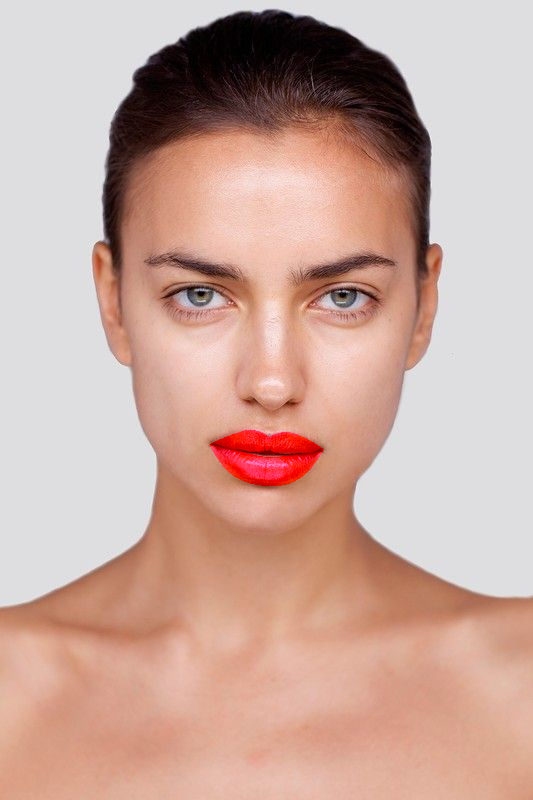

In [14]:
val = color.rgb2lab((img[x, y] / 255.).reshape(len(x), 1, 3)).reshape(len(x), 3)
L, A, B = mean(val[:, 0]), mean(val[:, 1]), mean(val[:, 2])
L1, A1, B1 = color.rgb2lab(np.array((b1 / 255., g1 / 255., r1 / 255.)).reshape(1, 1, 3)).reshape(3, )
L2, A2, B2  = L1 - L, A1 - A, B1 - B
val[:, 0] += L2
val[:, 1] += A2
val[:, 2] += B2

img[x, y] = color.lab2rgb(val.reshape(len(x), 1, 3)).reshape(len(x), 3) * 255
cv2_imshow(img)

# Apply layers of "blush"

In [15]:
r2, g2, b2 = (223., 91., 111.)
intensity = 0.5  # intensity of the blush
mid = mid_x[0]  # Approx x coordinate of center of the face.
im = cv2.imread('face1.jpg')
points = np.dstack((cheek_right_x, cheek_right_y))[0]
imOrg = im.copy()
height, width = im.shape[:2]

In [16]:
def get_boundary_points(x, y):
    tck, u = interpolate.splprep([x, y], s=0, per=1)
    unew = np.linspace(u.min(), u.max(), 1000)
    xnew, ynew = interpolate.splev(unew, tck, der=0)
    tup = c_[xnew.astype(int), ynew.astype(int)].tolist()
    coord = list(set(tuple(map(tuple, tup))))
    coord = np.array([list(elem) for elem in coord])
    return np.array(coord[:, 0], dtype=np.int32), np.array(coord[:, 1], dtype=np.int32)

In [17]:
def get_interior_points(x, y):
    intx = []
    inty = []

    def ext(a, b, i):
        a, b = round(a), round(b)
        intx.extend(arange(a, b, 1).tolist())
        inty.extend((ones(b - a) * i).tolist())

    x, y = np.array(x), np.array(y)
    xmin, xmax = amin(x), amax(x)
    xrang = np.arange(xmin, xmax + 1, 1)
    for i in xrang:
        ylist = y[where(x == i)]
        ext(amin(ylist), amax(ylist), i)
    return np.array(intx, dtype=np.int32), np.array(inty, dtype=np.int32)

In [18]:
def apply_blush_color(r=r2, g=g2, b=b2):
    global im
    val = color.rgb2lab((im / 255.)).reshape(width * height, 3)
    L, A, B = mean(val[:, 0]), mean(val[:, 1]), mean(val[:, 2])
    L1, A1, B1 = color.rgb2lab(np.array((b / 255., g / 255., r2 / 255.)).reshape(1, 1, 3)).reshape(3, )
    ll, aa, bb = (L1 - L) * intensity, (A1 - A) * intensity, (B1 - B) * intensity
    val[:, 0] = np.clip(val[:, 0] + ll, 0, 100)
    val[:, 1] = np.clip(val[:, 1] + aa, -127, 128)
    val[:, 2] = np.clip(val[:, 2] + bb, -127, 128)
    im = color.lab2rgb(val.reshape(height, width, 3)) * 255

In [19]:
def smoothen_blush(x, y):
    global imOrg
    imgBase = zeros((height, width))
    cv2.fillConvexPoly(imgBase, np.array(c_[x, y], dtype='int32'), 1)
    imgMask = cv2.GaussianBlur(imgBase, (51, 51), 0)
    imgBlur3D = np.ndarray([height, width, 3], dtype='float')
    imgBlur3D[:, :, 0] = imgMask
    imgBlur3D[:, :, 1] = imgMask
    imgBlur3D[:, :, 2] = imgMask
    imOrg = (imgBlur3D * im + (1 - imgBlur3D) * imOrg).astype('uint8')

/usr/local/lib/python3.6/dist-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][5]=x[0][0]
  (i, m, i)))
/usr/local/lib/python3.6/dist-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][5]=x[1][0]
  (i, m, i)))


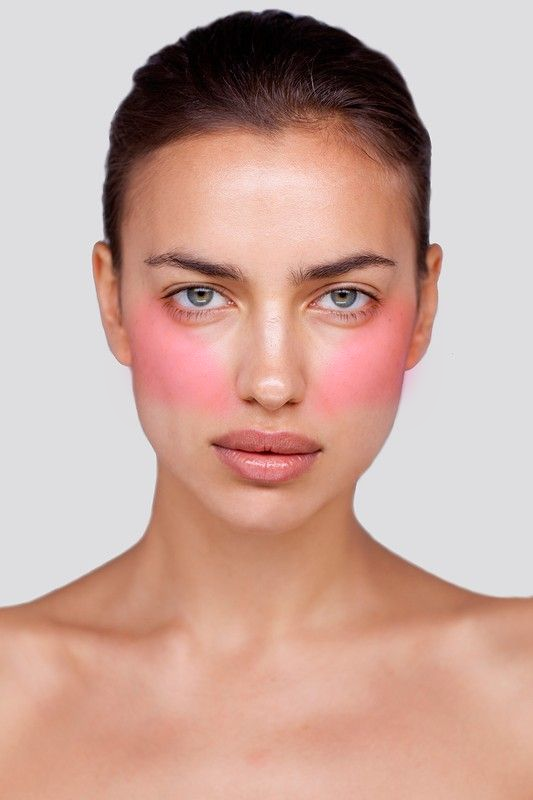

In [20]:
x, y = points[0:7, 0], points[0:7, 1]
x, y = get_boundary_points(x, y)
x, y = get_interior_points(x, y)
apply_blush_color()
smoothen_blush(x, y)
smoothen_blush(2 * mid * ones(len(x)) - x, y)
cv2_imshow(imOrg)